# Train a model to learn the shape in an image

Shape categories are: Ellipse, Rectangle, Triangle, Other  
Using Supervised Learning with Tensorflow

Data is received in 3 pickles that contains:
- Train images and labels
- Validation images and labels
- Test images and labels

---
Francois Robert

In [1]:
# Load packages

from IPython.display import display, Image
import imageio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline

import os
import sys
from six.moves import cPickle as pickle

In [2]:
import numpy as np

from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model   
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image

import datetime
datetime.datetime.now()

datetime.datetime(2022, 1, 3, 16, 51, 1, 248209)

In [3]:
from platform import python_version
print(python_version())

3.8.3


In [4]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [5]:
seed1=123  # 1231
np.random.seed(seed1)

In [6]:
# GPU Setting
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Define environment variables

In [7]:
BASEDIR = ".."

DATADIR = os.path.join(BASEDIR, "data")
TRAIN_DATADIR   = os.path.join(DATADIR, "train")
VAL_DATADIR     = os.path.join(DATADIR, "val")
TEST_DATADIR    = os.path.join(DATADIR, "test")

PICKLE_DIR     = os.path.join(BASEDIR, 'pickles')
TRAIN_DATAFILE = os.path.join(PICKLE_DIR, 'train.pickle')
VAL_DATAFILE   = os.path.join(PICKLE_DIR, 'val.pickle')
TEST_DATAFILE  = os.path.join(PICKLE_DIR, 'test.pickle')

MODEL_DIR      = os.path.join(BASEDIR, "saved_models")
model_name     = os.path.join(MODEL_DIR, "shapes.model.01") 

image_size     = 70 # Pixel width and height
pixel_depth    = 255.0  # Number of levels per pixel

## Load train, validation and test datasets from Pickles

In [8]:
with open(TRAIN_DATAFILE, 'rb') as f:
    train_dict = pickle.load(f)
with open(VAL_DATAFILE, 'rb') as f:
    val_dict = pickle.load(f)
with open(TEST_DATAFILE, 'rb') as f:
    test_dict = pickle.load(f)

In [9]:
output_labels = [
  'other',     #    0
  'ellipse',   #    1
  'rectangle', #    2
  'triangle']  #    3

In [10]:
## Construct train set
train_X = train_dict['train_data']
train_y = train_dict['train_labels']

In [11]:
## Construct validation set
val_X = val_dict['val_data']
val_y = val_dict['val_labels']

In [12]:
print("train_X shape: ", train_X.shape)
print("train_y shape: ", train_y.shape)

train_X shape:  (21393, 70, 70)
train_y shape:  (21393,)


In [13]:
print("val_X shape: ", val_X.shape)
print("val_y shape: ", val_y.shape)

val_X shape:  (3983, 70, 70)
val_y shape:  (3983,)


In [14]:
# Reshape images to add the channel (height = 70px, width = 70px , channel = 1)
X_train = train_X.reshape(-1,image_size,image_size,1)
X_val   = val_X.reshape(-1,image_size,image_size,1)

In [15]:
# Encode labels to one hot vectors (ex : C -> [0,0,1,0]) using Keras one Hot encoding
Y_train = to_categorical(train_y, num_classes = 4)
Y_val   = to_categorical(val_y, num_classes = 4)

In [16]:
X_train.shape

(21393, 70, 70, 1)

In [17]:
X_val.shape

(3983, 70, 70, 1)

In [18]:
Y_train.shape

(21393, 4)

In [19]:
Y_val.shape

(3983, 4)

In [20]:
def plot_sample(image, axs):
    axs.imshow(image.reshape(image_size, image_size), cmap="gray")

In [21]:
def display_images(X, Y):
    """ This function shows 25 images with their real labels"""

    fig = plt.figure(figsize=(13, 9))
    fig.subplots_adjust(hspace=0.2,wspace=0.2,
                        left=0, right=1, bottom=0, top=1)
    nb_pictures = 25

    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_pictures//5 , 5, i+1, xticks=[], yticks=[]) 
        plot_sample(X[i].reshape((image_size, image_size)), ax)
        ax.set_title("{}".format(output_labels[Y[i]]))
    plt.show()

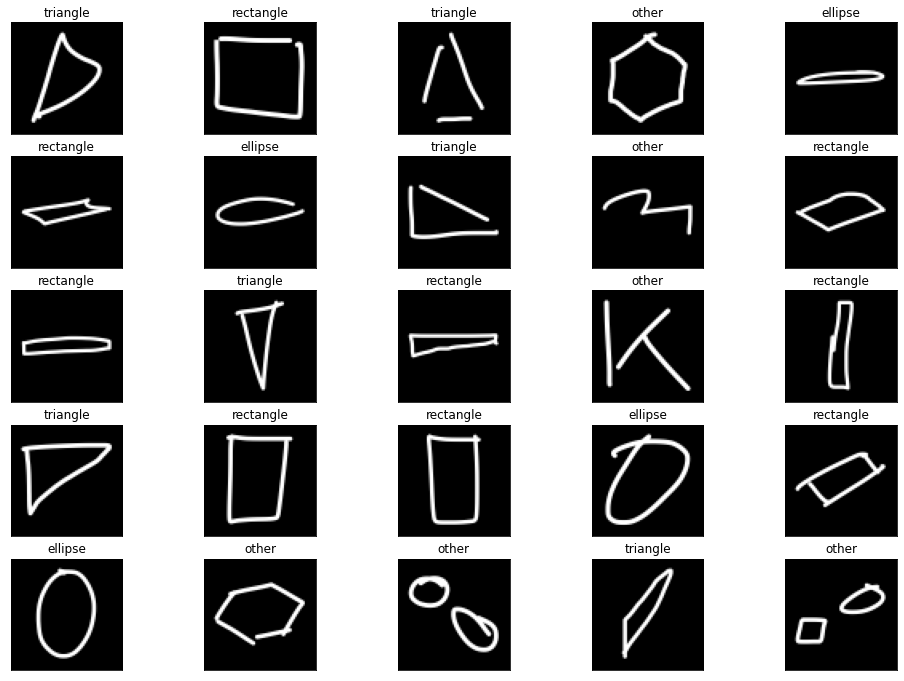

In [22]:
# Show 25 random images from the Train Set
indexes = np.arange(len(train_y))
np.random.shuffle(indexes)
first_random_indexes = indexes[:25]

display_images(X_train[first_random_indexes],train_y[first_random_indexes])

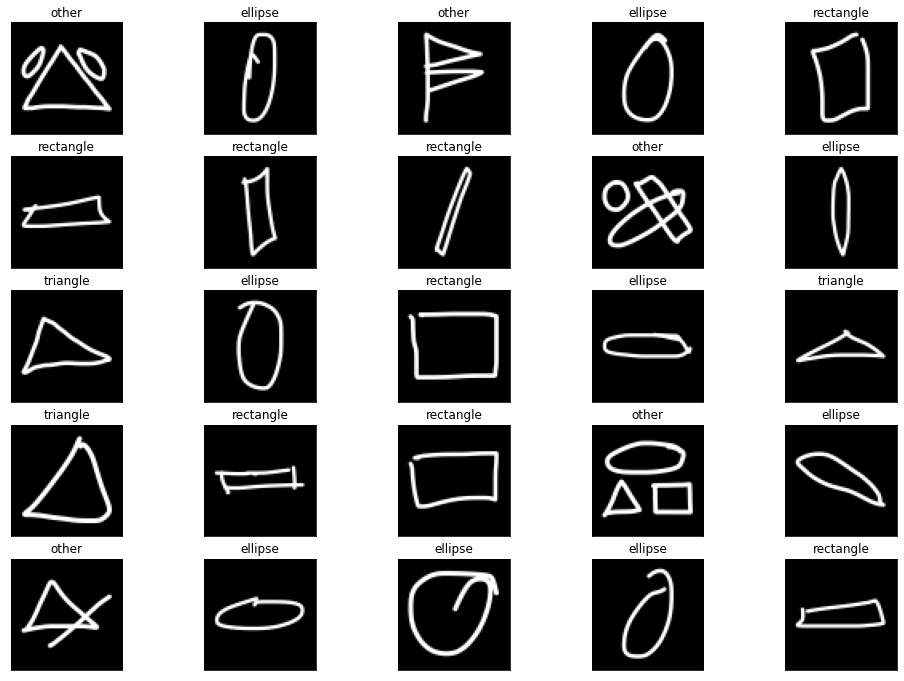

In [23]:
# Show 25 random images from the Validation Set
indexes = np.arange(len(val_y))
np.random.shuffle(indexes)
first_random_indexes = indexes[:25]

display_images(X_val[first_random_indexes], val_y[first_random_indexes])

In [24]:
tf.keras.backend.clear_session()

## Define Deep Learning Model

In [25]:
def get_model_cnn():
    # Set the CNN model using Keras functional API
    input_img = Input(shape=(image_size,image_size,1))

    x = Conv2D(32, (5, 5), padding='same')(input_img)  # Conv2D 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (5, 5), padding='same')(x)          # Conv2D 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3))(x)                          # Conv2D 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3))(x)                          # Conv2D 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3))(x)                         # Conv2D 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)                         # Conv2D 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x) 

    x = Flatten()(x)
    x = Dense(200)(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=output)
    
    return model

In [26]:
# select a model
model = get_model_cnn()

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 70, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 70, 70, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 70, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 35, 32)       

## Data augmentation: Full rotattion, Flip vert. and Horiz.

### Explain main use and how this augmentation helps overfit
### Explain Data all generated from the same tool, some some characteristics are constant

In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=180,                   # *** randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = [0.98, 1.02],          # Randomly zoom image a bit
        width_shift_range=0.0,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                # *** randomly flip images
        vertical_flip=True)                  # *** randomly flip images


datagen.fit(X_train)

## Define the optimizer

In [28]:
optimizer = Adam(lr=2e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

## Compile the model

In [29]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [30]:
# Keras callback to show the result of the best epoch in the model
# Intended to work with ModelCheckpoint callback.
class ShowBestEpochResult(tf.keras.callbacks.Callback):
    def __init__(self, on_param='val_loss', show_params=['val_loss', 'loss'], mode='min'):
        self.on_param    = on_param
        self.show_params = show_params
        self.mode        = mode

    def on_train_begin(self, logs=None):
        # The number of epoch at which the best value is found.
        self.best_epoch = 0

        # The best value found for the on_param.
        self.best = np.Inf
        if self.mode == 'max':
            self.best = np.NINF
            
        # The values on best epoch for each param in show_param.
        self.best_values = {}

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.on_param)
        save_as_best = (self.mode=='min' and current < self.best) or \
                       (self.mode=='max' and current > self.best)

        if save_as_best: 
            self.best = current
            for param in self.show_params:
                self.best_values[param] = logs.get(param)
            self.best_epoch = epoch

    def on_train_end(self, logs=None):
        print(f"BestEpochResult. Epoch: {self.best_epoch+1},", end=" ")

        for param in self.best_values:
            print(f"{param}: {self.best_values[param]:.5f},", end=" ")
        print(" ")

In [31]:
# Set a learning rate annealer
# TODO Explain lr reducing strategy.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=15, # 20
                                            verbose=1,
                                            factor=0.9, # 0.8
                                            min_lr=0.000000001)

## Fit the model with data Augmentation

In [32]:
# I like to start a few epoch with a small batch size because:
# - This basically makes the learning rate larger. https://openreview.net/pdf?id=B1Yy1BxCZ#:~:text=Increasing%20the%20batch%20size%20during%20training%20achieves%20similar%20results%20to,twice%20to%20illustrate%20the%20variance.
# - This covers to 0 to 80% of the accuracy curve, cleaning the graphs
epochs = 2 
batch_size = 32
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size, seed=seed1),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/2
668/668 [==============================] - 185s 277ms/step - loss: 0.7425 - accuracy: 0.7019 - val_loss: 0.3827 - val_accuracy: 0.8622
Epoch 2/2
668/668 [==============================] - 197s 296ms/step - loss: 0.3811 - accuracy: 0.8622 - val_loss: 0.2314 - val_accuracy: 0.9197


In [33]:
# Save the Best model
h5_path    = model_name + ".h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

best_epoch_results = ShowBestEpochResult(on_param='val_accuracy', show_params=['val_accuracy', 'accuracy', 'val_loss', 'loss'], mode='max')

callbacks_list = [learning_rate_reduction, checkpoint, best_epoch_results]

epochs = 28 #300
batch_size = 128
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size, seed=seed1),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=callbacks_list)

Epoch 1/28
167/167 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9271
Epoch 00001: val_accuracy improved from -inf to 0.94954, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 164s 980ms/step - loss: 0.2128 - accuracy: 0.9271 - val_loss: 0.1395 - val_accuracy: 0.9495
Epoch 2/28
167/167 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9373
Epoch 00002: val_accuracy improved from 0.94954 to 0.95280, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 166s 994ms/step - loss: 0.1817 - accuracy: 0.9373 - val_loss: 0.1258 - val_accuracy: 0.9528
Epoch 3/28
167/167 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9444
Epoch 00003: val_accuracy did not improve from 0.95280
167/167 [==============================] - 171s 1s/step - loss: 0.1644 - accuracy: 0.9444 - val_loss: 0.1449 - val_accuracy: 0.9455
Epoch 4/28
167/167 [================

Epoch 28/28
167/167 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9713
Epoch 00028: val_accuracy did not improve from 0.98117
167/167 [==============================] - 175s 1s/step - loss: 0.0860 - accuracy: 0.9713 - val_loss: 0.1081 - val_accuracy: 0.9636
BestEpochResult. Epoch: 23, val_accuracy: 0.98117, accuracy: 0.96694, val_loss: 0.05433, loss: 0.09304,  


## Plot the loss and accuracy curves for training and validation

In [34]:
def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss     = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

In [35]:
def plot_accuracy(hist,name,plt,RMSE_TF=False):
    loss     = hist['accuracy']
    val_loss = hist['val_accuracy']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

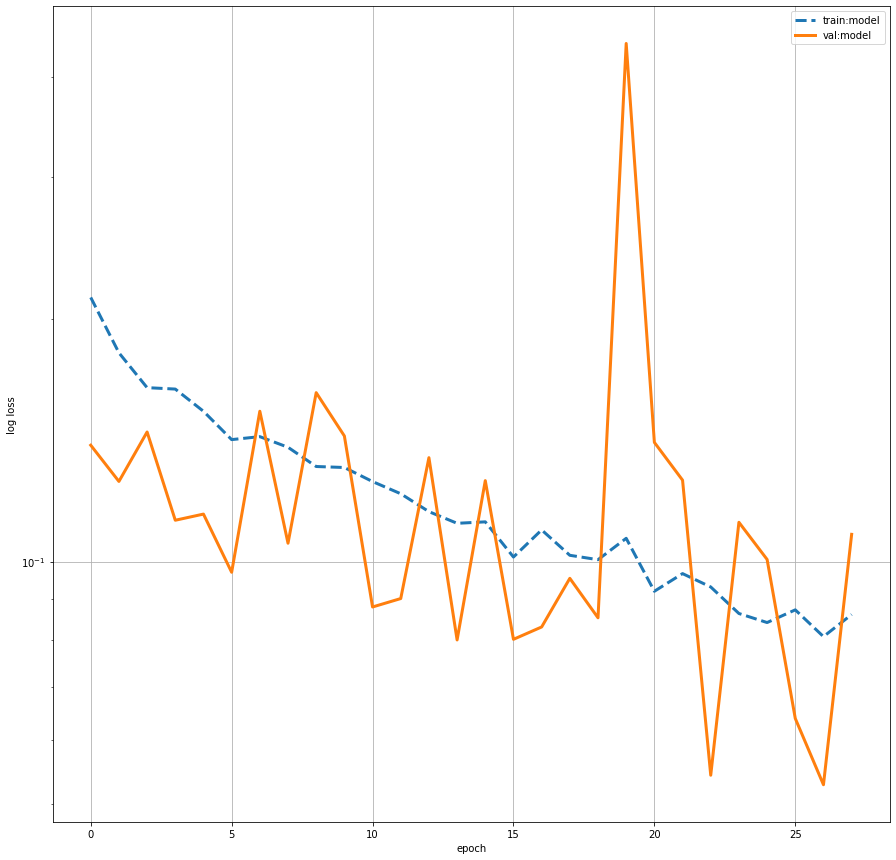

In [36]:
plt.figure(figsize=(15,15))
plot_loss(history.history,"model",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

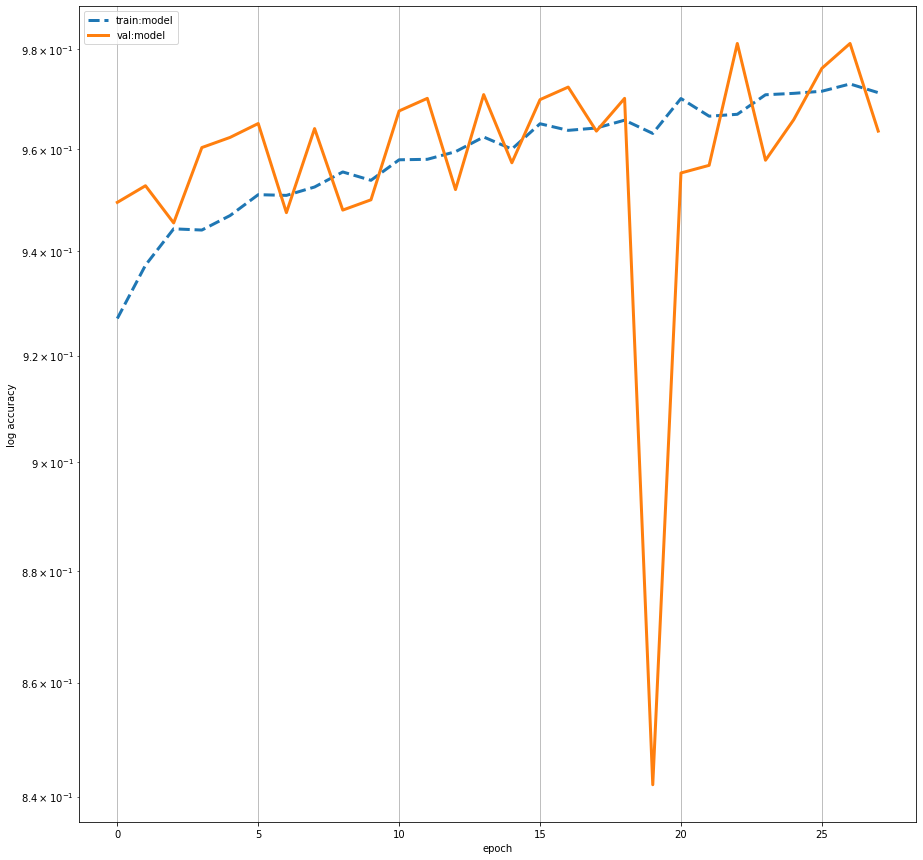

In [37]:
plt.figure(figsize=(15,15))
plot_accuracy(history.history,"model",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log accuracy")
plt.show()

## Delete the existing model + Load the best one

In [38]:
# Delete the existing model
del model

from tensorflow.keras.models import load_model
# Load last saved model
model = load_model(model_name + ".h5")

# Look at confusion matrix

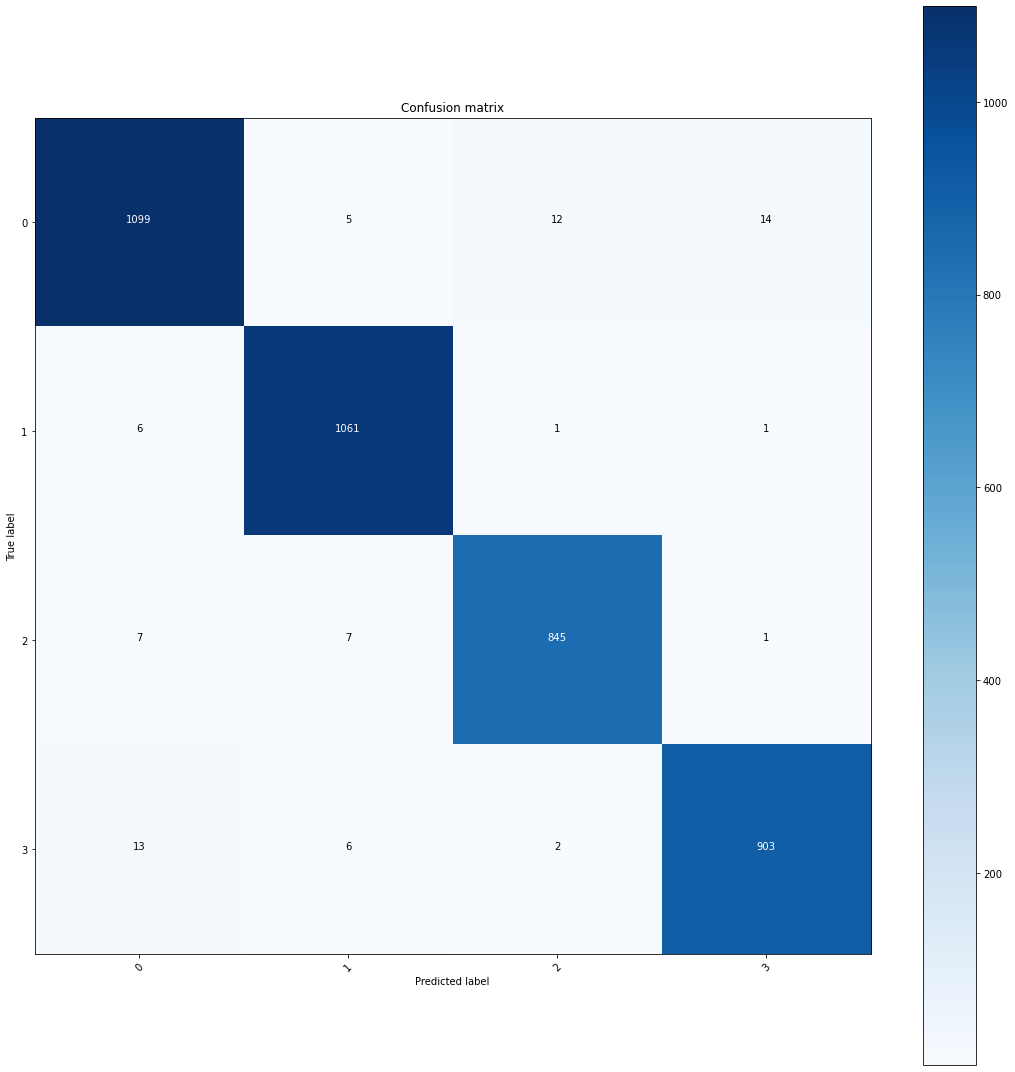

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4))

### Explain conclusion from Confusion matrix

In [40]:
print("Y_pred shape: ", Y_pred.shape)                 # Prediction for each image in the validaset set
print("Y_pred_classes shape: ", Y_pred_classes.shape) # Index of the font prediction for each image in the val. set
print("Y_true shape: ", Y_true.shape)                 # Index of the actual font for each image in the val. set
print("confusion_mtx shape: ", confusion_mtx.shape)   # Values in the confusion matrix shown above

Y_pred shape:  (3983, 4)
Y_pred_classes shape:  (3983,)
Y_true shape:  (3983,)
confusion_mtx shape:  (4, 4)


In [41]:
X_val.shape

(3983, 70, 70, 1)

## Analyze the errors

In [42]:
# Errors are difference between predicted labels and true labels. Error[i] is True if this is an error
errors = (Y_pred_classes - Y_true != 0)

# Y_pred_errors: List of Images in the validation set where prediction was bad
X_val_errors = X_val[errors]

# Y_true_errors: Index of the actual font in the validation set where prediction was bad
Y_true_errors = Y_true[errors]

# Y_pred_classes_errors: The list of indexes for font predictions that were bad
Y_pred_classes_errors = Y_pred_classes[errors]

# Y_pred_errors: Prediction for each font in the validation set where prediction was bad
Y_pred_errors = Y_pred[errors]

In [43]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows images with their predicted and real labels"""

    fig = plt.figure(figsize=(13, 15))
#     fig.subplots_adjust(hspace=0.15, wspace=0.2, left=0, right=1, bottom=0, top=1)
    fig.subplots_adjust(hspace=0.13, wspace=0.2, left=0, right=1, bottom=0, top=1)
    # hspace=0.1, wspace=0.2, left=0, right=1, bottom=0, top=1
    nb_pictures = len(errors_index)
    
    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_pictures//3 , 5, i+1, xticks=[], yticks=[]) 
        error = errors_index[i]
        plot_sample((img_errors[error]).reshape((image_size,image_size)), ax)
        ax.set_title("Pred: {}\nTrue : {}".format(output_labels[pred_errors[error]], output_labels[obs_errors[error]]))
    plt.show() 

## Show the biggest errors

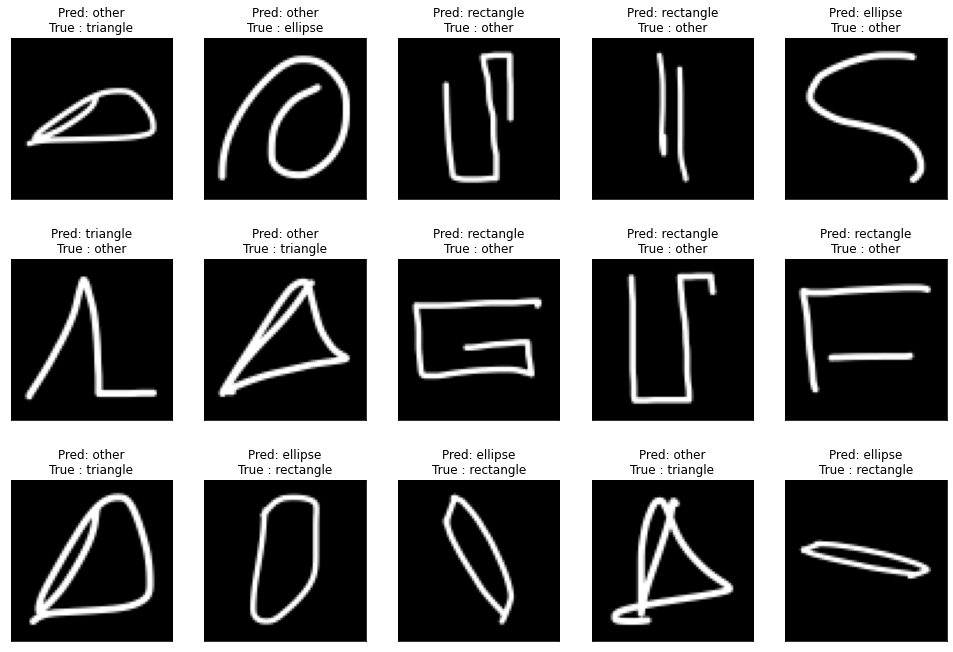

In [44]:
# Probabilities of the wrong predicted numbers. Prob for the bad choice
Y_pred_errors_prob = np.max(Y_pred_errors, axis = 1)

# Predicted probabilities of the true values in the error set. Prob for the good choice
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top errors 
most_important_errors = sorted_delta_errors[-15:]

# Show the top errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Predict for the test set

In [45]:
## Prepare test set
test_X = test_dict['test_data']
test_y = test_dict['test_labels']
print("test_X shape: ", test_X.shape)
print("test_y shape: ", test_y.shape)

X_test    = test_X.reshape(-1,image_size,image_size,1)
Y_test    = to_categorical(test_y, num_classes = 4)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

test_X shape:  (1923, 70, 70)
test_y shape:  (1923,)
X_test shape:  (1923, 70, 70, 1)
Y_test shape:  (1923, 4)


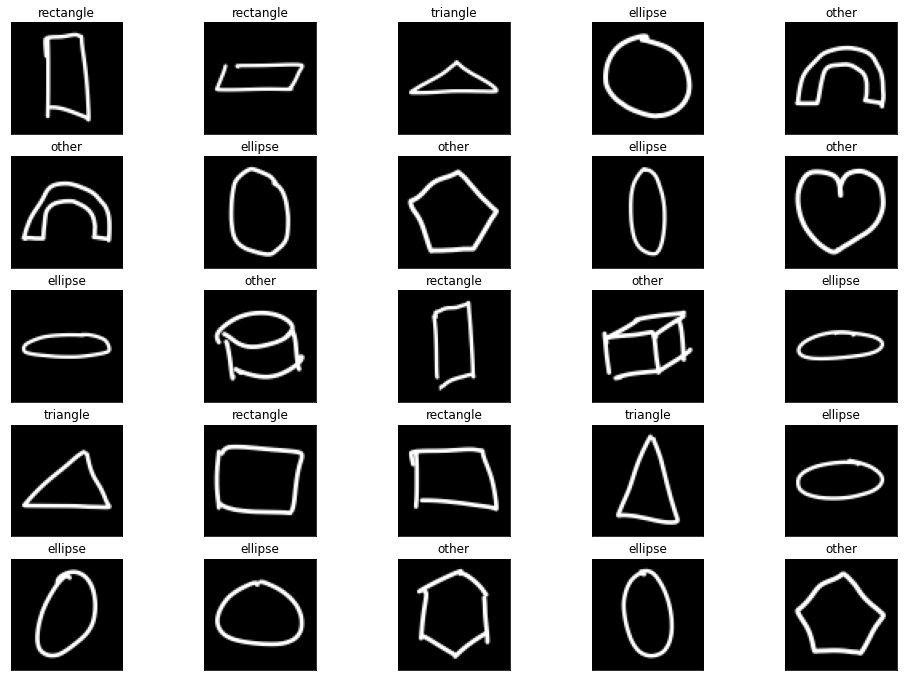

In [46]:
# Show 25 random images from the test Set
indexes = np.arange(len(test_y))
np.random.shuffle(indexes)
first_random_indexes = indexes[:25]

display_images(X_test[first_random_indexes], test_y[first_random_indexes])

## Show accuracy for the test set

In [47]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("test_acc: ", test_acc)

61/61 [==============================] - 6s 91ms/step - loss: 0.0054 - accuracy: 0.9990
test_acc:  0.9989599585533142


In [48]:
# All done
datetime.datetime.now()

datetime.datetime(2022, 1, 3, 18, 10, 37, 248147)

# Conclusions

### TODO